In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cpu")

In [2]:
NUM_ROUNDS = 10
NUM_CLIENTS = 10
BATCH_SIZE = 10
EPOCHS_PER_ROUND = 5
LEARNING_RATE = 0.1
BETA_1 = 0.9
BETA_2 = 0.999
EPSILON = 1e-7

In [3]:
df = pd.read_csv("processed_data/final_pre-processed.csv")

In [4]:
df = df.drop('Unnamed: 0',axis=1)
df["Ratings"] = df["Ratings"].astype(int)

In [5]:
df

,reviewText,Ratings
0,Microsoft Office is still the standard all the...,1
1,Been using Office for over twenty years. Stil...,0
2,Always liked Office Products. Expensive for a...,1
3,I have been using MS Office professional for d...,1
4,This is really a great buy. It breaks down to...,1
...,...,...
5163,Arrived as described. I was pleased with purc...,1
5164,Was not what I expected,0
5165,great buy,1
5166,"The product itself is quite good, in depth fix...",1


In [6]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['reviewText'], df['Ratings'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['Ratings'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [7]:
x_train_clients = np.array_split(train_text,NUM_CLIENTS)
y_train_clients = np.array_split(train_labels,NUM_CLIENTS)

x_test_clients = np.array_split(temp_text,NUM_CLIENTS)
y_test_clients = np.array_split(temp_labels,NUM_CLIENTS)

In [8]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<Axes: >

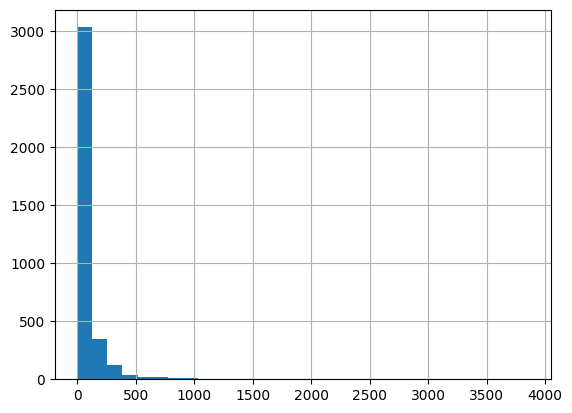

In [9]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [10]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [11]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32
df = pd.read_csv("processed_data/final_pre-processed.csv")
df = df.drop('Unnamed: 0',axis=1)
df["Ratings"] = df["Ratings"].astype(int)
train_text, temp_text, train_labels, temp_labels = train_test_split(df['reviewText'], df['Ratings'],random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['Ratings'])
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [12]:
for param in bert.parameters():
    param.requires_grad = False

In [13]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        
        self.bert = bert 
        
        # dropout layer
        self.dropout = nn.Dropout(0.1)
      
        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)
      
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
        
        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)
      
        # apply softmax activation
        x = self.softmax(x)

        return x

In [14]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)


# push the model to GPU
model = model.to('cpu')

In [24]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5) 

/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [25]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_labels), y= train_labels)

In [26]:
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to('cpu')

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [27]:
# function to train the model
def train():
    
    model.train()
    total_loss, total_accuracy = 0, 0
  
    # empty list to save model predictions
    total_preds=[]
  
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
        
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        
        # push the batch to gpu
        batch = [r.to('cpu') for r in batch]
 
        sent_id, mask, labels = batch
        
        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
  
      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [28]:

# function for evaluating the model
def evaluate():
    
    print("\nEvaluating...")
  
    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0
    
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):
        
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to('cpu') for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():
            
            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [29]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    114.
  Batch   100  of    114.

Evaluating...

Training Loss: 0.671
Validation Loss: 0.656

 Epoch 2 / 10
  Batch    50  of    114.
  Batch   100  of    114.

Evaluating...

Training Loss: 0.669
Validation Loss: 0.656

 Epoch 3 / 10
  Batch    50  of    114.
  Batch   100  of    114.

Evaluating...

Training Loss: 0.667
Validation Loss: 0.653

 Epoch 4 / 10
  Batch    50  of    114.
  Batch   100  of    114.

Evaluating...

Training Loss: 0.666
Validation Loss: 0.652

 Epoch 5 / 10
  Batch    50  of    114.
  Batch   100  of    114.

Evaluating...

Training Loss: 0.667
Validation Loss: 0.650

 Epoch 6 / 10
  Batch    50  of    114.
  Batch   100  of    114.

Evaluating...

Training Loss: 0.664
Validation Loss: 0.648

 Epoch 7 / 10
  Batch    50  of    114.
  Batch   100  of    114.

Evaluating...

Training Loss: 0.661
Validation Loss: 0.650

 Epoch 8 / 10
  Batch    50  of    114.
  Batch   100  of    114.

Evaluating...

Training Loss: 0.656
Validat

In [20]:
NUM_ROUNDS = 10
NUM_CLIENTS = 10
BATCH_SIZE = 10
EPOCHS_PER_ROUND = 5
LEARNING_RATE = 0.1
BETA_1 = 0.9
BETA_2 = 0.999
EPSILON = 1e-7

In [21]:
x_train_clients = np.array_split(train_text,NUM_CLIENTS)
y_train_clients = np.array_split(train_labels,NUM_CLIENTS)

x_test_clients = np.array_split(temp_text,NUM_CLIENTS)
y_test_clients = np.array_split(temp_labels,NUM_CLIENTS)

In [33]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

model1 = BERT_Arch(bert)
model1.load_state_dict(torch.load(path1))

# Load the weights from the second model file
path2 = 'saved_weights.pt'
model2 = BERT_Arch(bert)
model2.load_state_dict(torch.load(path2))

# Take the average of the model parameters
for param1, param2 in zip(model1.parameters(), model2.parameters()):
    param1.data = (param1.data + param2.data) / 2.0


In [34]:
# get predictions for test data
with torch.no_grad():
    preds = model1(test_seq.to('cpu'), test_mask.to('cpu'))
    preds = preds.detach().cpu().numpy()

In [35]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.32      0.44      0.37        95
           1       0.92      0.87      0.89       681

    accuracy                           0.82       776
   macro avg       0.62      0.65      0.63       776
weighted avg       0.84      0.82      0.83       776

